<a href="https://colab.research.google.com/github/pikanaeri/plm-model-comparison/blob/main/phrog-embedding-figures/Spectral_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installing Dependencies
!pip install statannotations

In [ ]:
#@title Importing Dependencies
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import random
import os

from sklearn import metrics
from sklearn.cluster import SpectralClustering

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

from statannotations.Annotator import Annotator
import itertools

import networkx as nx
from scipy.spatial.distance import squareform

phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan'
}

In [ ]:
#@title Reading in PHROGs Information
#@markdown * This code will take the labels from the PHROGs information list and place them in a dictionary mapping the PHROG number to the PHROG annotation
#@markdown * Download PHROG_index.tsv here: https://storage.googleapis.com/plm-model-comparison/PHROG_index.tsv
f = open("PHROG_index.tsv", "r")
labels = f.readline().strip().split("\t")

#label for each phrog family
phrog_dict = {}
#counts for each phrog family
phrog_count = {}
phrog_cnt = 0

for line in f:
  information = line.strip().split("\t")
  nm = int(information[0].split("phrog_")[1])
  phrog_dict[nm] = information[6]
  if information[6] in phrog_count:
    phrog_count[information[6]] += 1
  else:
    phrog_count[information[6]] = 1
  phrog_cnt += 1

for i in phrog_count:
  print(i, phrog_count[i])
print("total ", phrog_cnt)

f.close()

integration and excision 109
head and packaging 989
transcription regulation 337
connector 139
tail 1257
lysis 314
DNA, RNA and nucleotide metabolism 1105
other 580
unknown function 104106
moron, auxiliary metabolic gene and host takeover 468
total  109404


In [ ]:
#@title Reading in PHROGs Embeddings
#@markdown * This code will go through all of the embedding data
#@markdown * Dictionary stores number, embedding
#@markdown * Once the embedding vectors are created and averaged, store them into a final_average_embeddings folder and upload them here

categories = {}
embeddings = {}
os.chdir("final_average_embeddings")

for i in os.listdir():
  if i.endswith(".pkl"):
    f2 = open(i, "rb")
    i2 = i.replace(".pkl", "").replace("phrog_", "").replace("_averaged", "")
    num = int(i2)
    embeddings[num] = pickle.load(f2)
    if phrog_dict[num] in categories:
      categories[phrog_dict[num]].append(num)
    else:
      categories[phrog_dict[num]] = [num]
    f2.close()

phrog_dists = {'category':categories.keys(), 'phrogs':categories.values()}
phrog_dists = pd.DataFrame(phrog_dists)
phrog_dists.sort_values(by='category', inplace=True)
cs = set(phrog_dists['category'])

In [ ]:
phrog_dists

,category,phrogs
2,"DNA, RNA and nucleotide metabolism","[77, 100, 50, 96, 91, 62, 34, 47, 99, 93, 85, ..."
0,connector,"[25, 55, 37, 26, 75, 78, 27, 40, 82, 65, 5, 71]"
1,head and packaging,"[80, 104, 10, 15, 29, 9, 49, 74, 53, 57, 38, 8..."
4,integration and excision,"[66, 1, 95]"
7,lysis,"[13, 102, 20, 90, 7, 89]"
5,"moron, auxiliary metabolic gene and host takeover","[81, 61]"
6,other,"[56, 67, 54, 97, 87]"
3,tail,"[76, 43, 41, 30, 88, 24, 18, 32, 48, 39, 31, 1..."
8,transcription regulation,"[101, 3, 63, 4, 36, 8, 79, 35]"


In [ ]:
#@title Finding Category-Category Distances for Spectral Clustering
cat_vs_cat_dists = []
cat_vs_cat = {}
for i in range(len(cs)):
    c = list(cs)[i]
    dic = {}
    d = phrog_dists[phrog_dists['category'] == c]
    for j in range(len(cs)):
        if i == j:
            continue
        cc = list(cs)[j]
        nd = phrog_dists[phrog_dists['category'] == cc]
        c_vecs = []
        nd_vecs = []
        for ph in d['phrogs'].iloc[0]:
            c_vecs.append(embeddings[ph])
        print(nd['phrogs'])
        for ph in nd['phrogs'].iloc[0]:
            nd_vecs.append(embeddings[ph])
        c_vecs = np.array(c_vecs)
        nd_vecs = np.array(nd_vecs)
        sims = metrics.pairwise.cosine_similarity(c_vecs, nd_vecs)
        m_sims = np.mean(sims, axis=0)
        mm_sims = np.mean(m_sims, axis=0)
        cat_vs_cat_dists.append(zip([c]*len(m_sims), [cc]*len(m_sims), m_sims))
        if j > i:
            dic[cc] = {'weight': mm_sims}
    if len(dic) > 0:
        cat_vs_cat[c] = dic

cat_vs_cat_dists = [x for y in cat_vs_cat_dists for x in y]
df_cat_vs_cat_dists = pd.DataFrame(cat_vs_cat_dists, columns=['label1', 'label2', 'similarity'])
df_cat_vs_cat_dists.sort_values(by='label1', inplace=True)

4    [66, 1, 95]
Name: phrogs, dtype: object
8    [101, 3, 63, 4, 36, 8, 79, 35]
Name: phrogs, dtype: object
2    [77, 100, 50, 96, 91, 62, 34, 47, 99, 93, 85, ...
Name: phrogs, dtype: object
1    [80, 104, 10, 15, 29, 9, 49, 74, 53, 57, 38, 8...
Name: phrogs, dtype: object
7    [13, 102, 20, 90, 7, 89]
Name: phrogs, dtype: object
5    [81, 61]
Name: phrogs, dtype: object
3    [76, 43, 41, 30, 88, 24, 18, 32, 48, 39, 31, 1...
Name: phrogs, dtype: object
6    [56, 67, 54, 97, 87]
Name: phrogs, dtype: object
0    [25, 55, 37, 26, 75, 78, 27, 40, 82, 65, 5, 71]
Name: phrogs, dtype: object
8    [101, 3, 63, 4, 36, 8, 79, 35]
Name: phrogs, dtype: object
2    [77, 100, 50, 96, 91, 62, 34, 47, 99, 93, 85, ...
Name: phrogs, dtype: object
1    [80, 104, 10, 15, 29, 9, 49, 74, 53, 57, 38, 8...
Name: phrogs, dtype: object
7    [13, 102, 20, 90, 7, 89]
Name: phrogs, dtype: object
5    [81, 61]
Name: phrogs, dtype: object
3    [76, 43, 41, 30, 88, 24, 18, 32, 48, 39, 31, 1...
Name: phrogs, dtype: o

<ipython-input-32-63b5ec7a2f7e>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(list(widths.values())), vmax=max(list(widths.values())), clip=False),


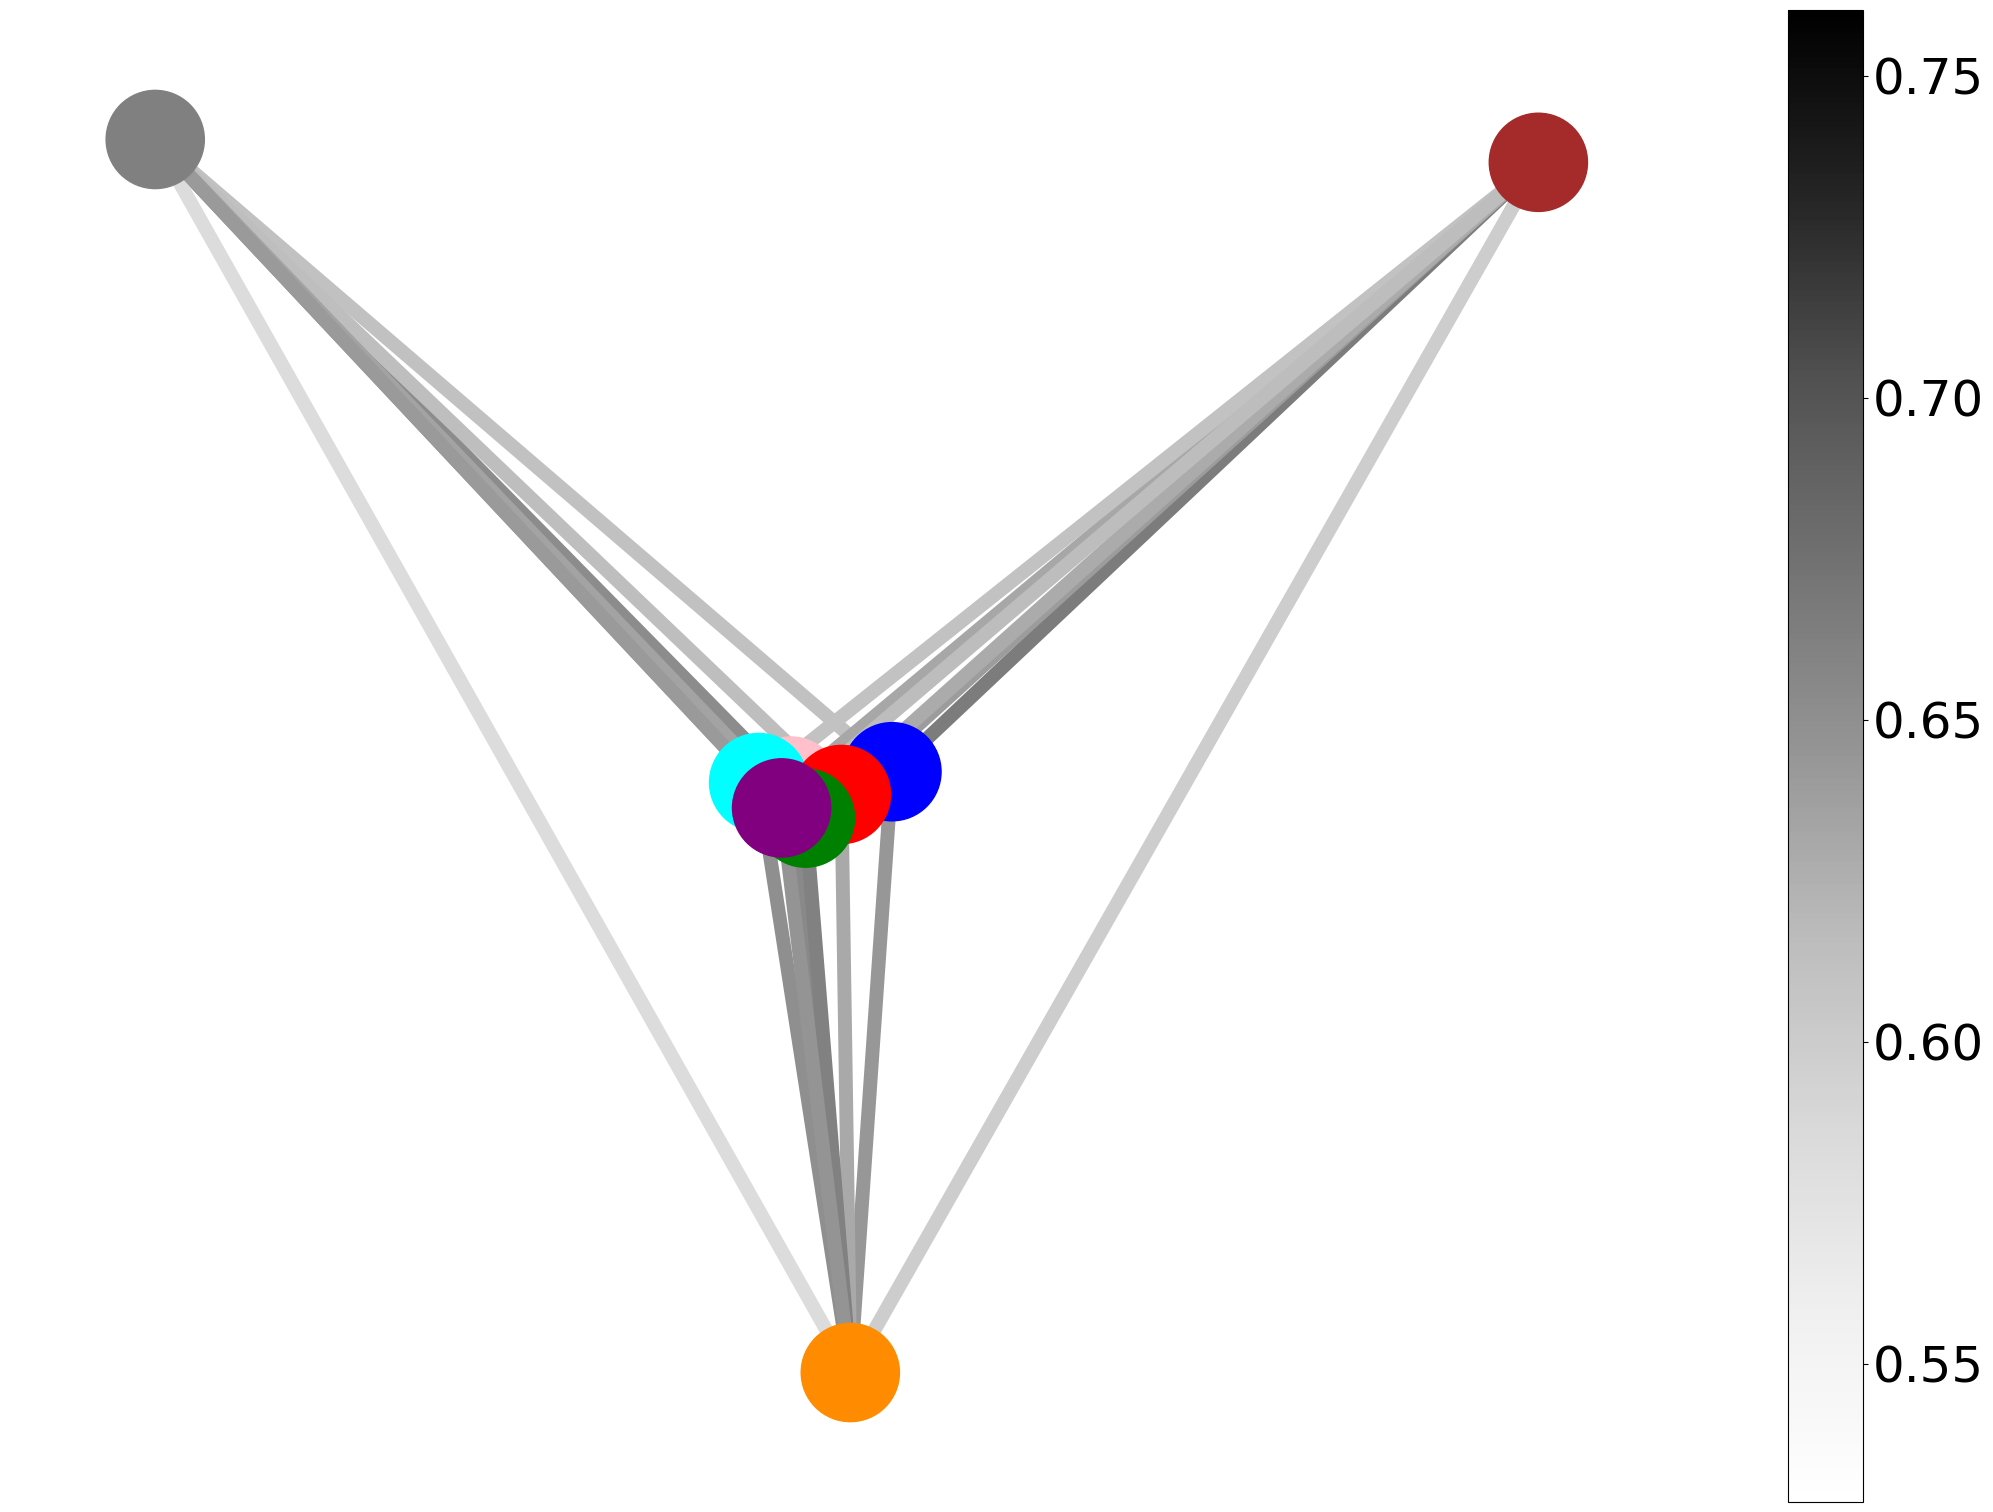

In [ ]:
#@title Saving Figure
G = nx.from_dict_of_dicts(cat_vs_cat)
nodelist = G.nodes()
network_colors = [phrog_palette[cc] for cc in nodelist]
plt.rcParams["figure.figsize"] = (22,16)
plt.rcParams['font.size'] = 36
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

pos = nx.spectral_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=5000,
                       node_color=network_colors
                      )
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=10,
                       #edge_color=list(widths.values()) / max(list(widths.values())),
                       edge_color=list(widths.values()),
                       edge_cmap=plt.cm.Greys
                      )


for v in set(nodelist):
    plt.scatter([],[], c=phrog_palette[v], label=v)

plt.box(False)
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(list(widths.values())), vmax=max(list(widths.values())), clip=False),
                                   cmap=plt.cm.Greys))

plt.tight_layout()
plt.savefig('inter_category_similarities_network_spectral.png', dpi=300)